A notebook for analyzing particle trajectories from Jun-July, 2015

In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import animation
import pandas as pd
import datetime

from salishsea_tools import viz_tools

%matplotlib inline

In [2]:
sns.set_color_codes()

In [3]:
traj = nc.Dataset('/ocean/nsoontie/MEOPAR/Ariane/results/2month-summer/'
                  'JDF/ariane_trajectories_qualitative.nc')
grid_B=nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
data=nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/01jul15/SalishSea_1d_20150701_20150701_grid_T.nc')
depth = data.variables['deptht'][:]

#Initial Positions

<matplotlib.contour.QuadContourSet instance at 0x7ffa65352878>

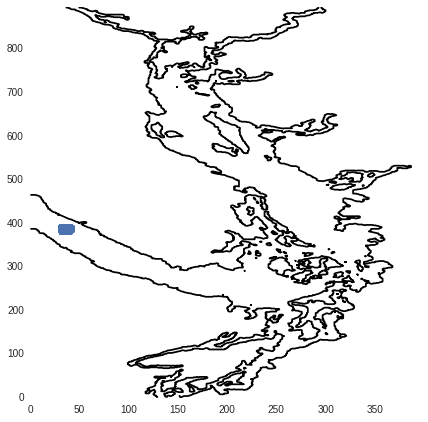

In [4]:
init_x = traj.variables['init_x']
init_y = traj.variables['init_y']
init_z = traj.variables['init_z']

fig,ax=plt.subplots(1,1,figsize=(7,7))
ax.plot(init_x,init_y,'bo')
viz_tools.plot_coastline(ax,grid_B)

#Final Positions

<matplotlib.contour.QuadContourSet instance at 0x7ffa6422d488>

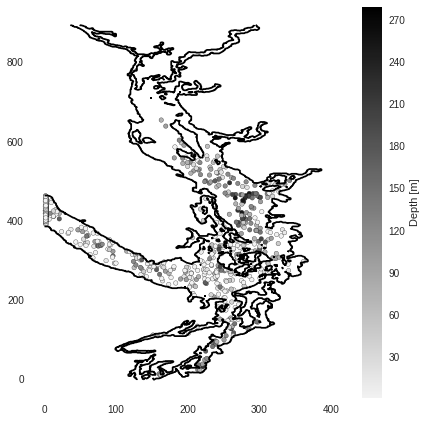

In [20]:
final_x = traj.variables['final_x']
final_y = traj.variables['final_y']
final_z = traj.variables['final_z']
final_age = traj.variables['final_age']
final_t = traj.variables['final_t']
z=np.array(final_z[:],dtype=int)


cmap = sns.light_palette('black', as_cmap=True)
fig,ax=plt.subplots(1,1,figsize=(7,7))
mesh=ax.scatter(final_x,final_y,c=depth[z],cmap=cmap)
cbar=plt.colorbar(mesh,ax=ax)
cbar.set_label('Depth [m]')
viz_tools.plot_coastline(ax,grid_B)

#Full trajectories

In [6]:
t_lat=traj.variables['traj_lat']
t_lon=traj.variables['traj_lon']
t_depth=traj.variables['traj_depth']
t_time=traj.variables['traj_time']

<matplotlib.contour.QuadContourSet instance at 0x7ffa5ebec950>

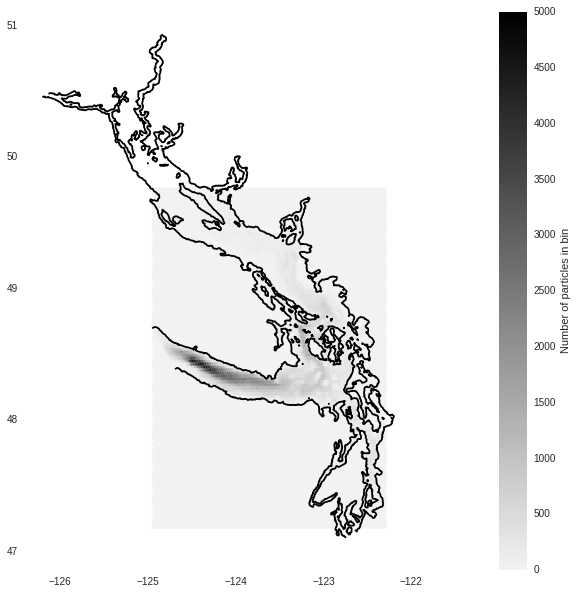

In [22]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
mesh=ax.hexbin(t_lon[:].flatten(),t_lat[:].flatten(),cmap=cmap,vmin=0,vmax=5000)
cbar=plt.colorbar(mesh,ax=ax)
cbar.set_label('Number of particles in bin')
viz_tools.plot_coastline(ax,grid_B,coords='map')

##Particles trapped against JdF boundary

It looks like there are many particles trapped against the JdF boundary. Why?

In [7]:
inds = np.where(final_x[:] <2)
inds[0].size

552

Many of the particles are trapped up against the JdF boundary. I believe this means they were 'ejected' from the domain.

###Average age and depth of ejected particles

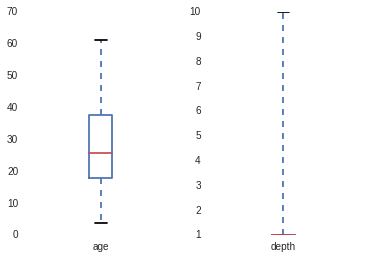

In [8]:
data = pd.DataFrame({'age': final_age[inds]/86400, 'depth': z[inds]})

fig,axs = plt.subplots(1,2)
data.boxplot('age', ax=axs[0], return_type='axes')
data.boxplot('depth', ax=axs[1], return_type='axes')

So, most particles are ejected between 20 and 40 days and near the surface.  But is that actual depth of the particle immediately before it was ejected or just some arbitrary depth the Arian sets for ejected particles ? Given the distribution, it looks arbitrary...

Try to determing depth another way: look up the depth of each particle at the index when the time is maximized.

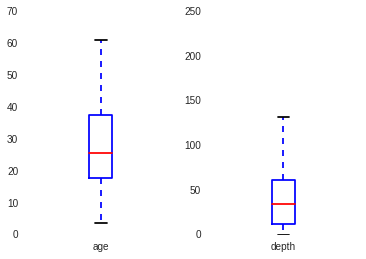

In [9]:
fig,axs = plt.subplots(1,2)
t_ind = np.argmax(t_time[:,inds[0]], axis=0)
t_depth = t_depth[:]
depth_eject= t_depth[t_ind,inds[0]]
axs[0].boxplot(np.max(t_time[:,inds[0]]*1464/24, axis=0))
axs[0].set_xticklabels(['age'])
axs[1].boxplot(-depth_eject)
axs[1].set_xticklabels(['depth'])

So, most particles are ejected from surfacce layer, above 50 m, but not at the very surface as indicated by final_z.

## Non-ejected particles

In [10]:
inds_good = np.where(final_x[:] >=2)
inds_good[0].size

t_lon_good = t_lon[:,inds_good[0]]
t_lat_good = t_lat[:,inds_good[0]]
t_depth_good = t_depth[:,inds_good[0]]

#Evolution

##Particles that end up in the deep SoG

In [11]:
inds_deep_SoG= np.where(np.logical_and(t_depth_good[-1,:]<= - 200, t_lat_good[-1,:]>48.9))

print inds_deep_SoG[0].size

9


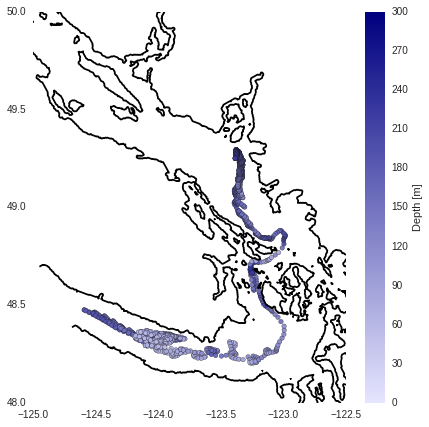

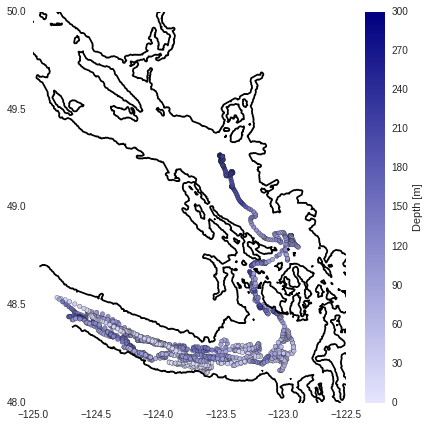

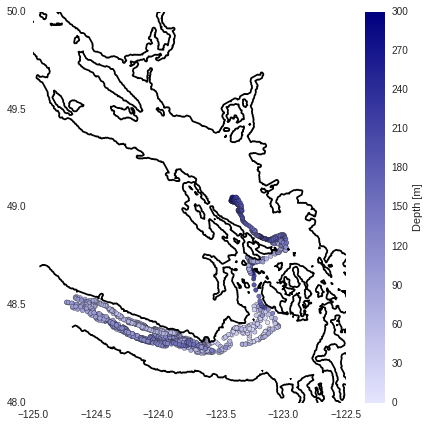

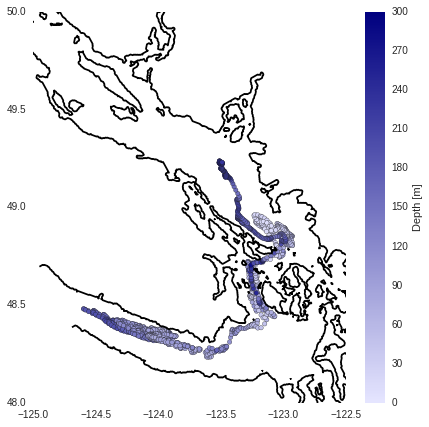

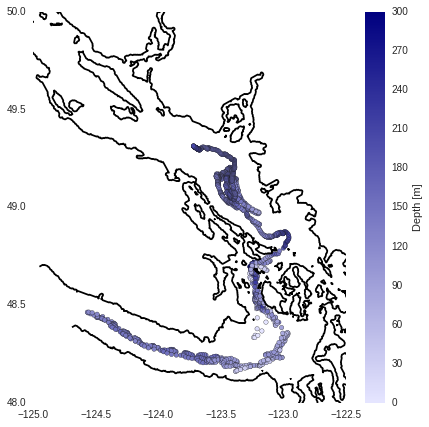

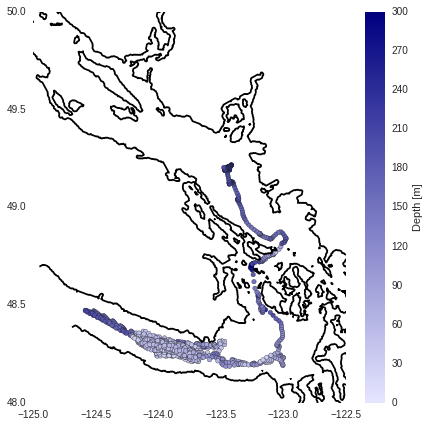

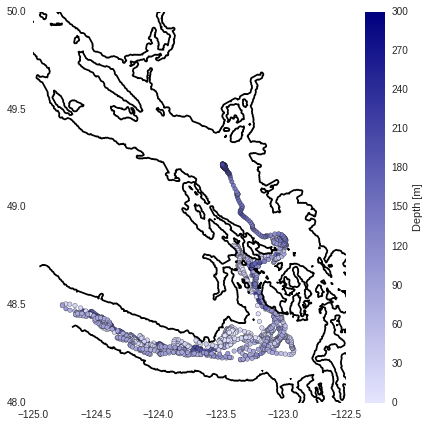

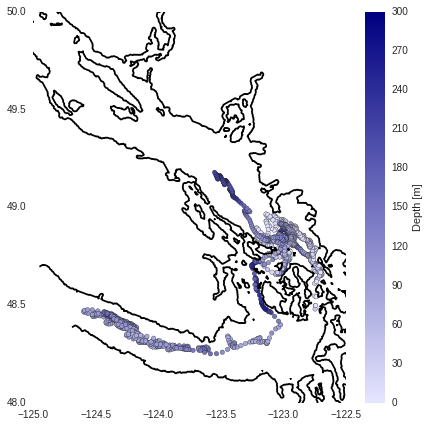

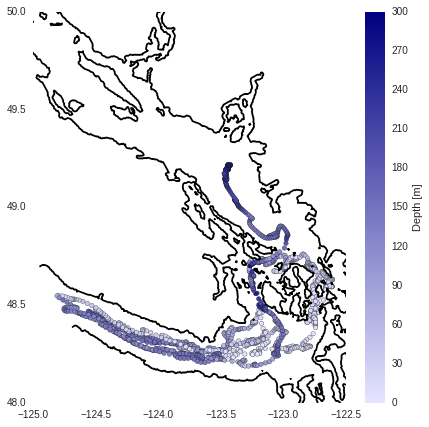

In [12]:
cmap = sns.light_palette('navy',as_cmap=True)
for n in np.arange(inds_deep_SoG[0].size):
    fig,ax = plt.subplots(1,1,figsize=(7,7))
    mesh=ax.scatter(t_lon_good[:,inds_deep_SoG[0][n]], t_lat_good[:,inds_deep_SoG[0][n]], 
               c=-t_depth_good[:,inds_deep_SoG[0][n]],vmin=0,vmax=300,cmap=cmap)
    viz_tools.plot_coastline(ax,grid_B,coords='map')
    cbar=plt.colorbar(mesh,ax=ax)
    cbar.set_label('Depth [m]')
    ax.set_xlim([-125,-122.5])
    ax.set_ylim([48,50])

##Animate

In [17]:
def animate_particle(t):
    """plot deep SoG particle trajectory for 24 time steps, begining with t"""
    ax.clear()
    for n, col in zip(np.arange(inds_deep_SoG[0].size), colors):
        cmap = sns.light_palette(col,as_cmap=True)
        mesh=ax.scatter(t_lon_good[t:t+24,inds_deep_SoG[0][n]], t_lat_good[t:t+24,inds_deep_SoG[0][n]], 
               c=-t_depth_good[t:t+24,inds_deep_SoG[0][n]],vmin=0,vmax=300,cmap=cmap)
    viz_tools.plot_coastline(ax,grid_B,coords='map')
    ax.set_xlim([-125,-122.5])
    ax.set_ylim([48,50])
    
    date = start + datetime.timedelta(hours=t)
    ax.set_title(date.strftime('%Y-%m-%d'))
    
    return mesh

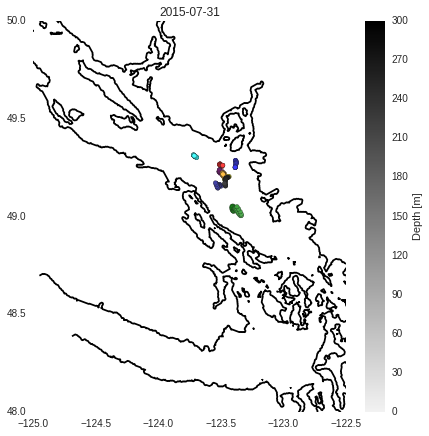

In [19]:
fig,ax = plt.subplots(1,1,figsize=(7,7))
colors= ['blue','red','green','purple','cyan','yellow','orange','navy','black']
start = datetime.datetime(2015,6,1)

mesh = animate_particle(0)
cbar=plt.colorbar(mesh,ax=ax)
cbar.set_label('Depth [m]')

#frmaes
framess=np.arange(1,t_lon_good.shape[0]-24)

#The animation function    
anim = animation.FuncAnimation(fig, animate_particle,frames=framess,  blit=True, repeat=False)

#A line that makes it all work
mywriter = animation.FFMpegWriter( fps=20, bitrate=10000)

#Save in current folder
anim.save('particle_deepSoG.mp4',writer=mywriter)